In [1]:
import os, math
import numpy as np
import pandas as pd
import seaborn as sns
import helpers

%matplotlib inline
import time
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import pandas as pd

from sklearn import svm
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.metrics import log_loss


In [2]:
y = pd.read_csv('./data/training_variants')
X = pd.read_csv('./data/training_text', sep="\|\|", engine="python", skiprows=1, names=["ID", "Text"])
text_train, text_test, variants_train, variants_test = train_test_split(X, y, test_size=0.2, \
                                                                        random_state=0, stratify=None)

train_full = variants_train.merge(text_train, how='inner', on='ID')
test_full = variants_test.merge(text_test, how='inner', on='ID')

print(train_full.shape)
print(test_full.shape)

(2656, 5)
(665, 5)


Use TF-IDF to Vectorize the texts， a feature selector, then SVM one-vs-all classification. 

In [3]:
start_time = time.time()

##Pipeline
tfidf = TfidfVectorizer(
    min_df=1, max_features=16000, strip_accents='unicode',lowercase =True,
    analyzer='word', use_idf=True, 
    smooth_idf=True, sublinear_tf=True, stop_words = 'english')
ffilter = SelectKBest(mutual_info_classif, k=3000)
clf = OneVsRestClassifier(svm.SVC(C=1.0, kernel='linear', probability=True,
                                 random_state=0))
##Data and labels
X_train = train_full["Text"]
X_test = test_full["Text"]
y_train = train_full["Class"]
y_test = test_full["Class"]
y_train_bi = label_binarize(train_full["Class"], classes=range(1, 10))
y_test_bi = label_binarize(test_full["Class"], classes=range(1, 10))

##Fitting
tfidf.fit(X_train)
Xtr_train = tfidf.transform(X_train)
print("--- %s seconds ---" % (time.time() - start_time))

ffilter.fit(Xtr_train, y_train)
print("--- %s seconds ---" % (time.time() - start_time))

clf.fit(ffilter.transform(Xtr_train), y_train_bi)
print("--- %s seconds ---" % (time.time() - start_time))

--- 104.89231896400452 seconds ---
--- 125.54605984687805 seconds ---
--- 894.1487109661102 seconds ---


In [4]:
#Evaluate
Xtr_test = tfidf.transform(X_test)
y_test_prob = clf.predict_proba(ffilter.transform(Xtr_test))
log_loss(y_test, y_test_prob, eps=1e-15, normalize=True, labels=range(1, 10))

1.2019120949968056

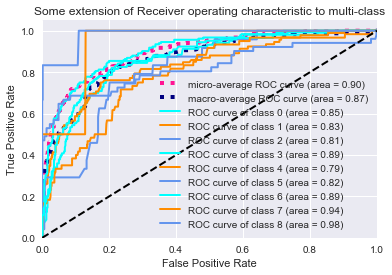

In [5]:
helpers.plot_roc_curve(y_test_bi, y_test_prob)

In [6]:
start_time = time.time()

X_submit = pd.read_csv('./data/test_text', sep="\|\|", engine="python", skiprows=1, names=["ID", "Text"])["Text"]
Xtr_submit = tfidf.transform(X_submit)
y_submit_prob = clf.predict_proba(ffilter.transform(Xtr_submit)) 

print("--- %s seconds ---" % (time.time() - start_time))

--- 440.3083372116089 seconds ---


In [7]:
with open('./data/submission.csv', 'w') as f:
    f.write('ID,class1,class2,class3,class4,class5,class6,class7,class8,class9\n')
    for i in range(y_submit_prob.shape[0]):
        f.write(str(i)+',')
        for j in range(y_submit_prob.shape[1]):
            f.write(str(y_submit_prob[i][j]))
            if j<8:
                f.write(',')
        f.write('\n')